In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import dask
import seaborn as sns
xr.set_options(display_style='html')

import intake
from xmip.preprocessing import rename_cmip6,promote_empty_dims

import cftime

/Users/shreyatrivedi/miniconda3/lib/python3.7/site-packages/gribapi/__init__.py:25: UserWarning: ecCodes 2.21.0 or higher is recommended. You are running version 2.15.0
  "You are running version {}".format(min_recommended_version_str, __version__)


In [2]:
#For RF:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import shap
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
ZW3_Historical = xr.open_dataset('/Volumes/SHREYA/Ch3-ZW3_Extreme_Analysis/Extreme_ZW3-II/New_NC_Files/ZW3_Index_Historical_CMIP.NCAR.CESM2.piControl.Amon.gn.nc').zg.load()
ZW3_Historical = ((ZW3_Historical-ZW3_Historical.mean())/ZW3_Historical.std())

In [4]:
SIT = xr.open_dataset('sithick_CMIP.NCAR.CESM2.historical.SImon.nc').sithick.squeeze().load()
SIC = xr.open_dataset('siconc_CMIP.NCAR.CESM2.historical.SImon.nc').siconc.squeeze().load()
TAS = xr.open_dataset('TAS_CMIP.NCAR.CESM2.historical.Amon.nc').tas.squeeze().load()
PSL = xr.open_dataset('PSL_CMIP.NCAR.CESM2.historical.Amon.nc').psl.squeeze().load()
TOS = xr.open_dataset('TOS_CMIP.NCAR.CESM2.historical.Omon.nc').tos.squeeze().load()
# AREA = dset_dict1['CMIP.NCAR.CESM2.historical.Ofx.gn'].areacello.squeeze().load()

In [5]:
VA = xr.open_dataset('/Volumes/SHREYA/Ch2-Relationships/VA_850_CESM2.historical-MONTHLY-SH.nc').va.load()

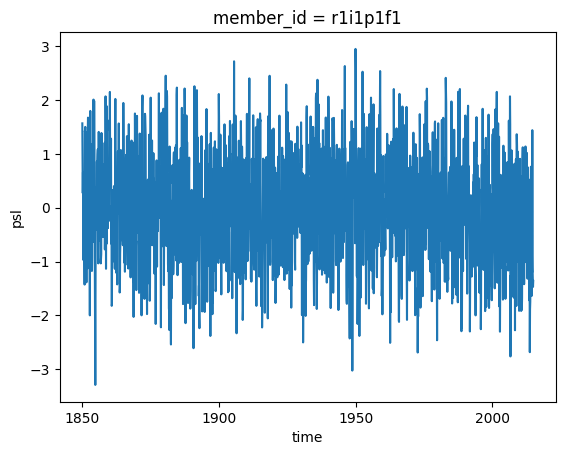

In [6]:
# Calculate ASL index:

ASL_array = PSL.sel(lat=slice(-75,-60),lon=slice(180, 310))
ASL_Index = ASL_array.min(('lat','lon'))
ASL_Index = ((ASL_Index-ASL_Index.mean())/ASL_Index.std())

ASL_Index.plot()
plt.show()

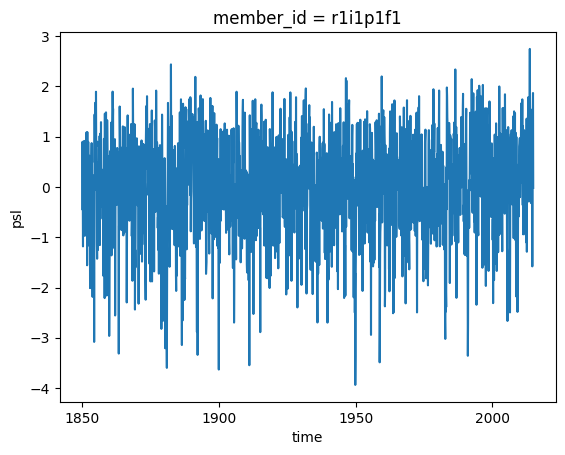

In [7]:
# Calculate SAM index:

SAM_array = PSL.sel(lat=slice(-65, -40)).mean(dim='lon')

clim = SAM_array.groupby('time.month').mean(dim='time')
anom = SAM_array.groupby('time.month') - clim
stdev = SAM_array.groupby('time.month').std(dim='time')
norm = anom.groupby('time.month') / stdev

sam_timeseries = norm.sel(lat=-40,method='nearest') - norm.sel(lat=-65,method='nearest')

sam_timeseries = ((sam_timeseries-sam_timeseries.mean())/sam_timeseries.std())

sam_timeseries.plot()
plt.show()

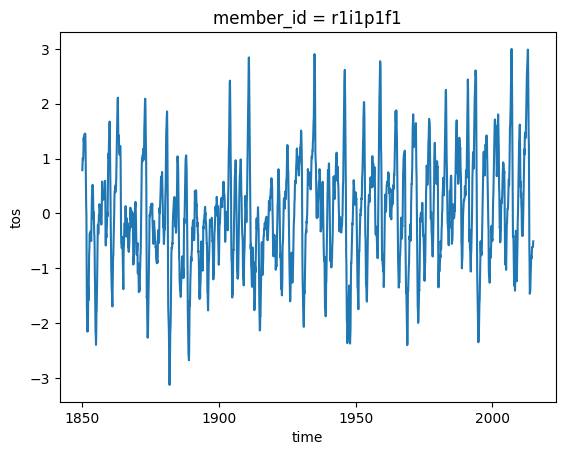

In [8]:
# ENSO: NINO-3.4 Index

ENSO_array = TOS.where((TOS.lat < 5) & (TOS.lat > -5) & (TOS.lon > 190) & (TOS.lon < 240), drop=True)

clim_ENSO = ENSO_array.groupby('time.month').mean(dim='time')
Anom_ENSO = ENSO_array.groupby('time.month') - clim_ENSO

ENSO_Index = Anom_ENSO.mean(('nlat','nlon'))

ENSO_Index = ((ENSO_Index-ENSO_Index.mean())/ENSO_Index.std())

ENSO_Index.plot()
plt.show()

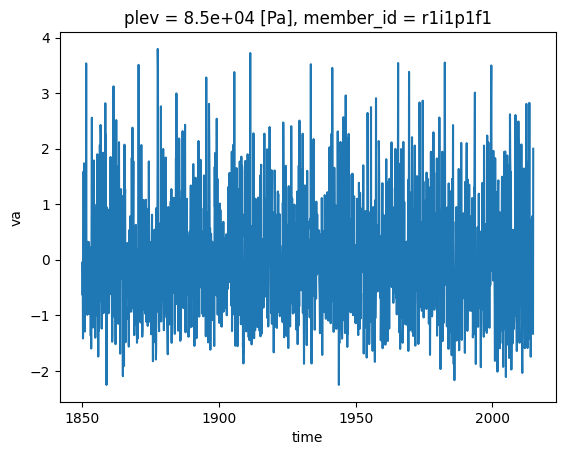

In [9]:
"""Calculate the meridional wind index.
Represents the average amplitude of the meridional wind
over the 70S to 40S latitude band.

Expected input: Meridional wind
"""

# Calculate index
MI_Array = (VA ** 2) ** 0.5  # absolute value
mi_timeseries = MI_Array.mean(dim=['lat', 'lon'])

mi_timeseries = ((mi_timeseries-mi_timeseries.mean())/mi_timeseries.std())


mi_timeseries.plot()
plt.show()

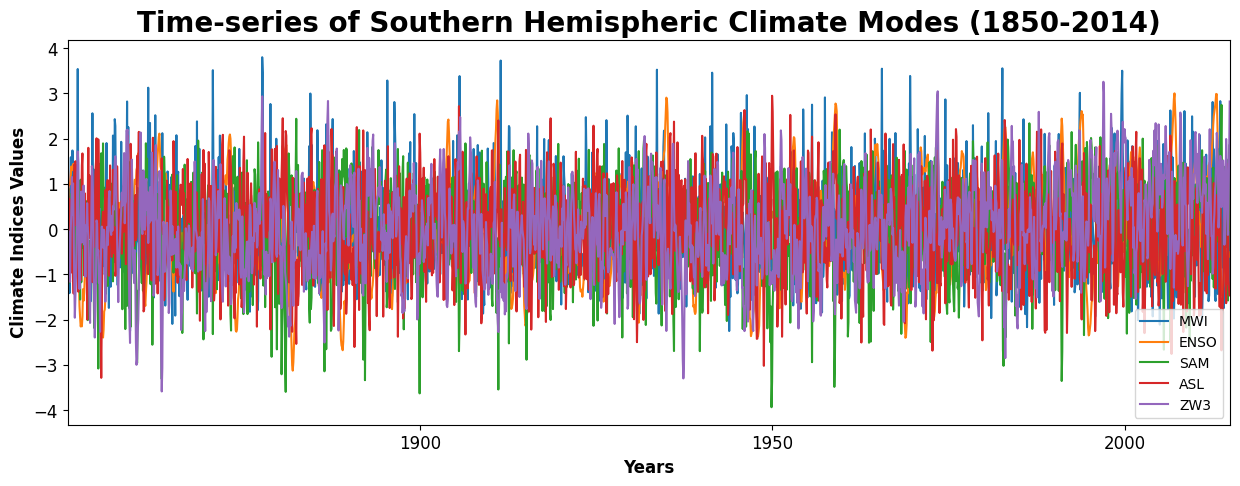

In [254]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

mi_timeseries.plot(ax=ax)
ENSO_Index.plot(ax=ax)
sam_timeseries.plot(ax=ax)
ASL_Index.plot(ax=ax)
ZW3_Historical.plot(ax=ax)


plt.xlabel("Years",fontsize=12,fontweight="bold")
plt.ylabel("Climate Indices Values",fontsize=12,fontweight="bold")

plt.title("Time-series of Southern Hemispheric Climate Modes (1850-2014)",fontsize=20,fontweight="bold")

plt.legend(['MWI','ENSO','SAM','ASL','ZW3'], loc='best')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid()
plt.margins(x=0)

plt.savefig('Climate_Indices.png')
plt.show()

In [11]:
# supress warnings
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import os
# import packages
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import xesmf as xe
from xarrayutils.utils import linear_trend
# from cmcrameri import cm
import matplotlib.path as mpath
%matplotlib inline

In [12]:
SIT = SIT.where((SIT.lat<-50)&(SIT.lat>-90),drop=True)
SIC = SIC.where((SIC.lat<-50)&(SIC.lat>-90),drop=True)

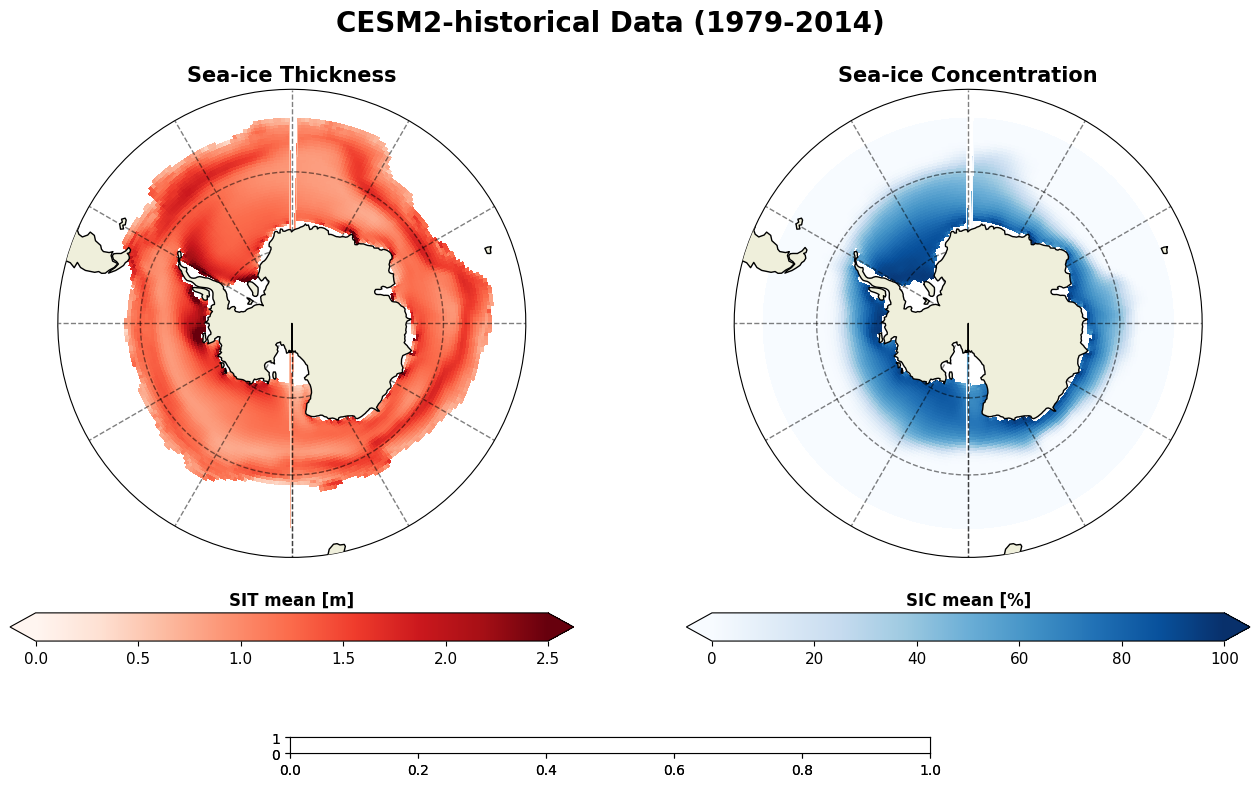

In [13]:
fig = plt.figure(figsize=[16,8])

ax = plt.subplot(1,2,1,projection = ccrs.SouthPolarStereo())
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())
dmeridian = 30  # spacing for lines of meridian
dparallel = 15  # spacing for lines of parallel 
num_merid = int(360/dmeridian + 1)
num_parra = int(90/dparallel + 1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                  xlocs=np.linspace(-180, 180, num_merid), \
                  ylocs=np.linspace(0, -90, num_parra), \
                  linestyle="--", linewidth=1, color='k', alpha=0.5)

theta = np.linspace(0, 2*np.pi, 120)
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
center, radius = [0.5, 0.5], 0.5
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

data = SIT.mean('time')
CS = ax.pcolormesh(data.lon,data.lat,data,
                   transform=ccrs.PlateCarree(),cmap = plt.cm.Reds,vmin=0,vmax=2.5)
plt.title("Sea-ice Thickness",fontsize=15,fontweight="bold")

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]

cbar = fig.colorbar(CS, ax=ax,  orientation='horizontal',extend='both', pad=0.09)
cbar.ax.tick_params(labelsize=11)
cbar.ax.set_title('SIT mean [m]',fontsize=12,fontweight="bold")


ax = plt.subplot(1,2,2,projection = ccrs.SouthPolarStereo())
ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
ax.set_extent([0.005, 360, -90, -45], crs=ccrs.PlateCarree())
dmeridian = 30  # spacing for lines of meridian
dparallel = 15  # spacing for lines of parallel 
num_merid = int(360/dmeridian + 1)
num_parra = int(90/dparallel + 1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), \
                  xlocs=np.linspace(-180, 180, num_merid), \
                  ylocs=np.linspace(0, -90, num_parra), \
                  linestyle="--", linewidth=1, color='k', alpha=0.5)

theta = np.linspace(0, 2*np.pi, 120)
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
center, radius = [0.5, 0.5], 0.5
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)  #without this; get rect bound

data = SIC.mean('time')
CS = ax.pcolormesh(data.lon,data.lat,data,
                   transform=ccrs.PlateCarree(),cmap = plt.cm.Blues,vmin=0,vmax=100)
plt.title("Sea-ice Concentration",fontsize=15,fontweight="bold")

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) #[left, bottom, width, height]

cbar = fig.colorbar(CS, ax=ax,  orientation='horizontal',extend='both', pad=0.09)
cbar.ax.tick_params(labelsize=11)
cbar.ax.set_title('SIC mean [%]',fontsize=12,fontweight="bold")

plt.suptitle("CESM2-historical Data (1979-2014)",fontsize=20,fontweight="bold")


# plt.savefig("CESM2_historical_Averages.png")

plt.show()

In [14]:
## Selecting regions:

In [15]:
def crop_regions(data,min_lon,max_lon):
    region = data.where((data.lon>min_lon)&(data.lon<max_lon),drop=True)
    return(region)

In [16]:
#East Antarctic:
Lats1 = -90,-50
Lons1 = 70,170
EA = crop_regions(SIT,70,170)


#King Hakon VII:
Lats2 = -90,-50
Lons2 = -10,70
KH = crop_regions(SIT,-10,70)


#Ross-Amundsen:
Lats3 = -90,-50
Lons3 = 165,250
RAM = crop_regions(SIT,165,250)


#Amundsen-Bellingshausen:
Lats4 = -90,-50
Lons4 = 250,290
ABS = crop_regions(SIT,250,290)


#Weddell:
Lats5 = -90,-50
Lons5 = 290,349
WED = crop_regions(SIT,290,349)

In [180]:
df = pd.DataFrame()
df['SIT']  = data.mean(('ni','nj')).values
df['ZW3']  = ZW3_Historical.values
df['ASL']  = ASL_Index.values
df['SAM']  = sam_timeseries.values
df['ENSO'] = ENSO_Index.values
df['MWI']  = mi_timeseries.values
df.fillna(0,inplace=True)

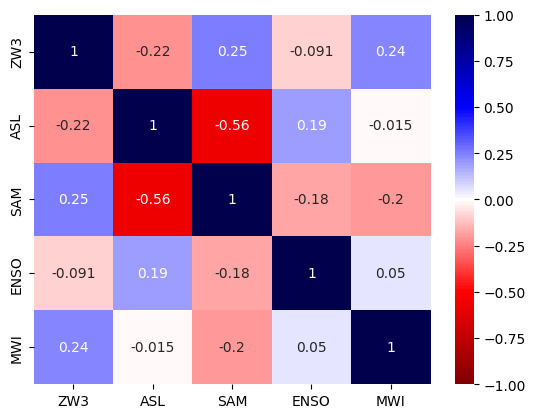

In [255]:
sns.heatmap(df.iloc[:,1:].cov(),cmap='seismic_r',vmin=-1,vmax=1,annot=True)
# plt.savefig('CorrMap.png')
plt.show()

## RFR Analysis

### Seasonal analysis:

In [17]:
def sel_mon(data,months):
    mon_data = data.where(data.time.dt.month.isin([months]), drop=True)
    return(mon_data)

Adv_mon = [4,5,6,7,8] 
Ret_mon = [10,11,12,1,2]

In [18]:
# Create a dataframe for the variables for different regions: 

def Create_seasonal_df(data,season):
    df = pd.DataFrame()
    df['SIT']  = sel_mon(data.mean(('ni','nj')),season).values
    df['ZW3']  = sel_mon(ZW3_Historical,season).values
    df['ASL']  = sel_mon(ASL_Index,season).values
    df['SAM']  = sel_mon(sam_timeseries,season).values
    df['ENSO'] = sel_mon(ENSO_Index,season).values
    df['MWI']  = sel_mon(mi_timeseries,season).values
    df.fillna(0,inplace=True)
    return(df)

In [257]:
def RFR_Algorithm(df):
    # Labels are the values we want to predict
    labels = np.array(df['SIT'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features= df.drop('SIT', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)
    
    # Split the data into train and test sets for SIT:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                                test_size = 0.25, 
                                                                                random_state = 42)
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)
    
    # Create a pipeline with StandardScaler and RandomForestRegressor
    rf_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('rf', RandomForestRegressor(n_estimators=1000, random_state=42))]) 
    
    # Train the model on training data
    rf_pipeline.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf_pipeline.predict(test_features)

    # Evaluate the model (replace with your preferred regression metric)
    rmse = mean_squared_error(test_labels, predictions,squared=False)
    print("\nRoot Mean Squared Error:", round(rmse,4))

    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2))
    
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / test_labels)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%')

    # Mean squared error (MSE)
    mse = mean_squared_error(test_labels.ravel(), predictions)

    # R-squared scores
    r2 = r2_score(test_labels, predictions)

    # Print metrics
    print('Mean Squared Error:', round(mse, 2))
    print('R-squared scores:', round(r2, 2),'\n')
    
    # Access the RandomForestRegressor model inside the pipeline
    rf_model = rf_pipeline.named_steps['rf']

    # Get numerical feature importances
    importances = list(rf_model.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    
    
    # Create a figure and axis object
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot(121)
    
    
    # Get the indices that would sort the importances in ascending order
    sorted_indices = np.argsort(importances)

    # Sort the importances and feature names accordingly
    sorted_importances = [importances[i] for i in sorted_indices]
    sorted_features = [feature_list[i] for i in sorted_indices]

    # List of x locations for plotting
    x_values = list(range(len(sorted_importances)))

    # Make a horizontal bar chart
    plt.barh(x_values, sorted_importances)

    # Tick labels for y axis (horizontal bar chart)
    ax.set_yticks(x_values,labels=sorted_features)
    ax.set_yticklabels(sorted_features)  # Use sorted feature names

    # Axis labels and title
    ax.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax.set_title('Variable Importances', fontsize=12, fontweight='bold')
    
    
    
    # Create an explainer object
    explainer = shap.Explainer(rf_model)

    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(test_features)
    
    
    # Plot the SHAP summary plot
#     shap.summary_plot(shap_values, test_features, plot_type="bar",feature_names=feature_list,
#                       show=False)
#     ax.set_xlabel("Average impact on model output magnitude", fontsize=10, fontweight='bold')
#     ax.set_title("|Mean SHAP|",fontsize=12,fontweight="bold")

    ax = fig.add_subplot(122)

    # Plot individual SHAP value plots
    shap.summary_plot(shap_values, test_features, feature_names=feature_list,show=False)    
    ax.set_title("SHAP Value",fontsize=12,fontweight="bold")
    ax.set_xlabel("Impact on model output", fontsize=10,  fontweight='bold')

    plt.show()

In [259]:
def SHAP_Plots(df):
    # Labels are the values we want to predict
    labels = np.array(df['SIT'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features= df.drop('SIT', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)
    
    # Split the data into train and test sets for SIT:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                                test_size = 0.25, 
                                                                                random_state = 42)
    
    # Create a pipeline with StandardScaler and RandomForestRegressor
    rf_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('rf', RandomForestRegressor(n_estimators=1000, random_state=42))]) 
    
    # Train the model on training data
    rf_pipeline.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf_pipeline.predict(test_features)

        
    # Access the RandomForestRegressor model inside the pipeline
    rf_model = rf_pipeline.named_steps['rf']

           
    # Create an explainer object
    explainer = shap.Explainer(rf_model)

    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(test_features)
    

    # Plot individual SHAP value plots
    shap.summary_plot(shap_values, test_features, feature_names=feature_list,show=False)    
    ax.set_title("SHAP Value",fontsize=12,fontweight="bold")
    ax.set_xlabel("Impact on model output", fontsize=10,  fontweight='bold')

    plt.show()

In [269]:
# ax = fig.add_subplot(513)
# SHAP_Plots(Create_seasonal_df(RAM,Adv_mon))
# ax.set_title('Ross-Amundsen')

# ax = fig.add_subplot(514)
# SHAP_Plots(Create_seasonal_df(KH,Adv_mon))
# ax.set_title('King Hakon VII')

# ax = fig.add_subplot(515)
# SHAP_Plots(Create_seasonal_df(WED,Adv_mon))
# ax.set_title('Weddell Sea')

# plt.savefig('SHAP_ADV.png')

# plt.show()

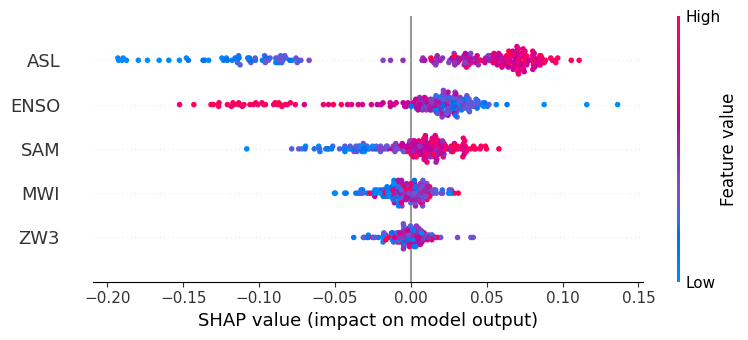

In [277]:
# fig = plt.figure(figsize=(16,8))

SHAP_Plots(Create_seasonal_df(WED,Ret_mon))

# plt.savefig('SHAP_ADV_EA.png')

plt.show()

In [56]:
RMSE_ADV = [0.1687,0.3117,0.1677,0.1845,0.1977]
RMSE_RET = [0.1218,0.2389,0.2217,0.1711,0.1807]

In [57]:
df_ADV_Importance_Regional = pd.DataFrame()
df_RET_Importance_Regional = pd.DataFrame()
# EA, ABS, RAM, KH, WED

In [58]:
df_ADV_Importance_Regional['MWI'] =[0.239,0.211,0.233,0.206,0.186]
df_ADV_Importance_Regional['ENSO']=[0.22,0.209,0.216,0.207,0.215]
df_ADV_Importance_Regional['ZW3'] =[0.191,0.21,0.213,0.211,0.222]
df_ADV_Importance_Regional['ASL'] =[0.178,0.182, 0.162,0.165,0.2]
df_ADV_Importance_Regional['SAM'] =[0.172,0.188,0.177,0.21,0.177]
df_ADV_Importance_Regional ['RMSE_ADV'] = RMSE_ADV

df_ADV_Importance_Regional.index = ['East Antarctic', 'Amundsen-Bellingshauen', 'Ross-Amundsen', 
                                    'King Hakon VII', 'Weddell']

In [59]:
df_RET_Importance_Regional['MWI'] =[0.099,0.127,0.166,0.092,0.14]
df_RET_Importance_Regional['ENSO']=[0.096,0.138,0.118,0.081,0.209]
df_RET_Importance_Regional['ZW3'] =[0.09,0.126,0.132,0.078,0.133]
df_RET_Importance_Regional['ASL'] =[0.55,0.442,0.418,0.577,0.356]
df_RET_Importance_Regional['SAM'] =[0.165,0.167,0.166,0.173,0.163]
df_RET_Importance_Regional['RMSE_RET'] = RMSE_RET

df_RET_Importance_Regional.index = ['East Antarctic', 'Amundsen-Bellingshauen', 'Ross-Amundsen', 
                                    'King Hakon VII', 'Weddell']

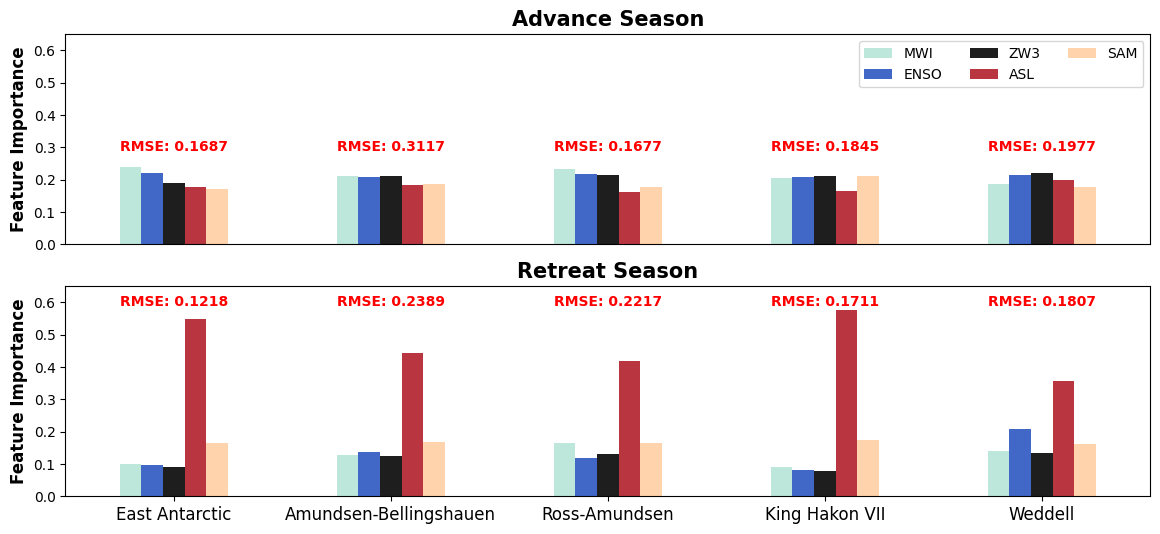

In [256]:
fig, (axes) = plt.subplots(2,1,figsize=(14,6))

ax = axes[0]
ax.set_ylim(0,0.65)

df_ADV_Importance_Regional.iloc[:,0:5].plot(kind='bar',ax=ax, cmap='icefire')
ax.set_title('Advance Season',fontsize=15, fontweight='bold')
ax.set_ylabel('Feature Importance',fontsize=12, fontweight='bold')
ax.set_xticks([])
ax.legend(loc='upper right',ncol=3)

# Display RMSE values as text on each bar
for i, value in enumerate(df_ADV_Importance_Regional['RMSE_ADV']):
    ax.text(i, 0.3, f'RMSE: {value:.4f}', ha='center', va='center', color='red', fontweight='bold', fontsize=10)

ax = axes[1]
ax.set_ylim(0,0.65)

df_RET_Importance_Regional.iloc[:,0:5].plot(kind='bar',ax=ax, cmap='icefire',legend=False)
ax.set_title('Retreat Season',fontsize=15, fontweight='bold')
ax.set_ylabel('Feature Importance',fontsize=12, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center',fontsize=12)  # Use set_xticklabels for rotation

# Display RMSE values as text on each bar
for i, value in enumerate(df_RET_Importance_Regional['RMSE_RET']):
    ax.text(i, 0.6, f'RMSE: {value:.4f}', ha='center', va='center', color='red', fontweight='bold', fontsize=10)
    
plt.savefig('Feature_importances.png')
plt.show()

## Selecting the most important features for the Weddell regions in two seasons:

In [156]:
Wed_Adv = Create_seasonal_df(ABS,Adv_mon)
Wed_Ret = Create_seasonal_df(ABS,Ret_mon)

Wed_Adv.drop(columns=['MWI', 'SAM'],inplace=True)
Wed_Ret.drop(columns=['MWI', 'ZW3'],inplace=True)

In [145]:
def RFR_Curve(df):
    # Labels are the values we want to predict
    labels = np.array(df['SIT'])

    # Remove the labels from the features
    # axis 1 refers to the columns
    features= df.drop('SIT', axis = 1)

    # Saving feature names for later use
    feature_list = list(features.columns)

    # Convert to numpy array
    features = np.array(features)
    
    # Split the data into train and test sets for SIT:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    
    # Create a pipeline with StandardScaler and RandomForestRegressor
    rf_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('rf', RandomForestRegressor(n_estimators=1000, random_state=42))]) 
    
    # Train the model on training data
    rf_pipeline.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf_pipeline.predict(test_features)

    # Evaluate the model (replace with your preferred regression metric)
    rmse = mean_squared_error(test_labels, predictions,squared=False)
    
    return(predictions,test_labels,rmse)

In [146]:
# REC curve
def rec(m, n, tol):
    if not type(m) == 'numpy.ndarray':
        m = np.array(m) #change m to a np array
    if not type(n) == 'numpy.ndarray':
        n = np.array(n) #change n to a np array

    l = m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [193]:
tol_max = 20
rec_WED_Adv=[]

for i in range(tol_max):
    rec_WED_Adv.append(rec(RFR_Curve(Create_seasonal_df(WED,Adv_mon))[0], 
                          RFR_Curve(Create_seasonal_df(WED,Adv_mon))[1], i))
    
    
rec_EA_Adv=[]

for i in range(tol_max):
    rec_EA_Adv.append(rec(RFR_Curve(Create_seasonal_df(EA,Adv_mon))[0], 
                          RFR_Curve(Create_seasonal_df(EA,Adv_mon))[1], i))
    
    
rec_ABS_Adv=[]

for i in range(tol_max):
    rec_ABS_Adv.append(rec(RFR_Curve(Create_seasonal_df(ABS,Adv_mon))[0], 
                          RFR_Curve(Create_seasonal_df(ABS,Adv_mon))[1], i))
    
    
rec_RAM_Adv=[]

for i in range(tol_max):
    rec_RAM_Adv.append(rec(RFR_Curve(Create_seasonal_df(RAM,Adv_mon))[0], 
                          RFR_Curve(Create_seasonal_df(RAM,Adv_mon))[1], i))
    
rec_KH_Adv=[]

for i in range(tol_max):
    rec_KH_Adv.append(rec(RFR_Curve(Create_seasonal_df(KH,Adv_mon))[0], 
                          RFR_Curve(Create_seasonal_df(KH,Adv_mon))[1], i))


In [194]:
tol_max = 20
rec_WED_Ret=[]

for i in range(tol_max):
    rec_WED_Ret.append(rec(RFR_Curve(Create_seasonal_df(WED,Ret_mon))[0], 
                          RFR_Curve(Create_seasonal_df(WED,Ret_mon))[1], i))
    
    
rec_EA_Ret=[]

for i in range(tol_max):
    rec_EA_Ret.append(rec(RFR_Curve(Create_seasonal_df(EA,Ret_mon))[0], 
                          RFR_Curve(Create_seasonal_df(EA,Ret_mon))[1], i))
    
    
rec_ABS_Ret=[]

for i in range(tol_max):
    rec_ABS_Ret.append(rec(RFR_Curve(Create_seasonal_df(ABS,Ret_mon))[0], 
                          RFR_Curve(Create_seasonal_df(ABS,Ret_mon))[1], i))
    
    
rec_RAM_Ret=[]

for i in range(tol_max):
    rec_RAM_Ret.append(rec(RFR_Curve(Create_seasonal_df(RAM,Ret_mon))[0], 
                          RFR_Curve(Create_seasonal_df(RAM,Ret_mon))[1], i))
    
rec_KH_Ret=[]

for i in range(tol_max):
    rec_KH_Ret.append(rec(RFR_Curve(Create_seasonal_df(KH,Ret_mon))[0], 
                          RFR_Curve(Create_seasonal_df(KH,Ret_mon))[1], i))


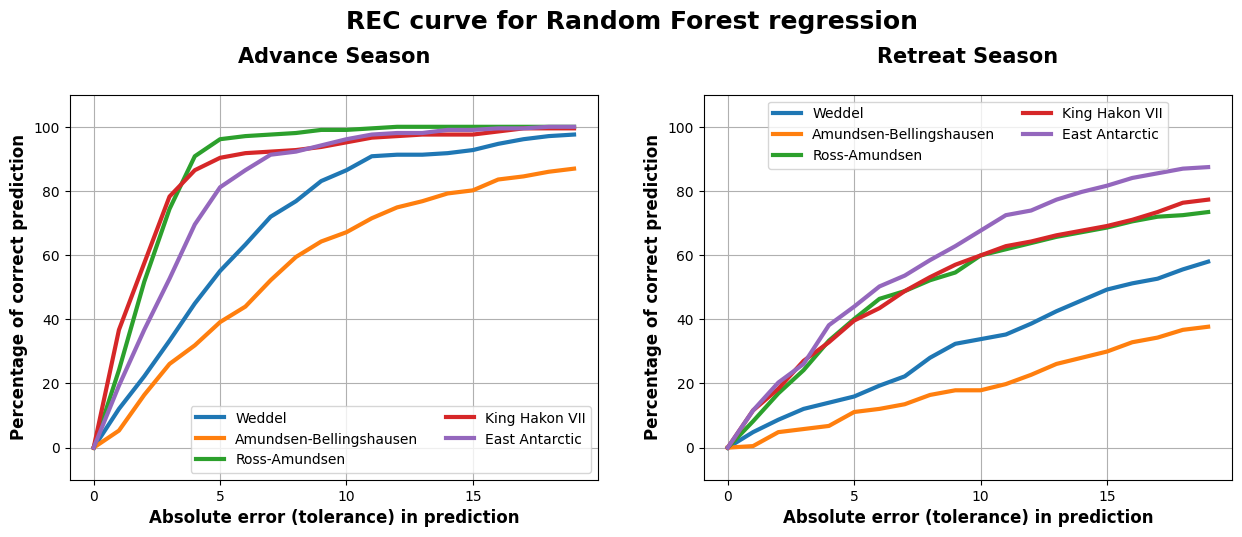

In [280]:
tol_max = 20

fig, (axes) = plt.subplots(1,2,figsize=(15,5))

ax = axes[0]

ax.set_title("Advance Season\n",fontsize=15,fontweight='bold')
ax.set_xlabel("Absolute error (tolerance) in prediction",fontsize=12,fontweight='bold')
ax.set_ylabel("Percentage of correct prediction",fontsize=12,fontweight='bold')
ax.set_xticks([i*5 for i in range(tol_max+1)])
ax.set_ylim(-10,110)
ax.set_yticks([i*20 for i in range(6)])
ax.grid(True)
ax.plot(range(tol_max),rec_WED_Adv, label='Weddel',linewidth=3)
ax.plot(range(tol_max),rec_ABS_Adv, label='Amundsen-Bellingshausen',linewidth=3)
ax.plot(range(tol_max),rec_RAM_Adv, label='Ross-Amundsen',linewidth=3)
ax.plot(range(tol_max),rec_KH_Adv, label='King Hakon VII',linewidth=3)
ax.plot(range(tol_max),rec_EA_Adv, label='East Antarctic',linewidth=3)

ax.legend(loc='lower right',ncol=2)

ax = axes[1]

ax.set_title("Retreat Season\n",fontsize=15,fontweight='bold')
ax.set_xlabel("Absolute error (tolerance) in prediction",fontsize=12,fontweight='bold')
ax.set_ylabel("Percentage of correct prediction",fontsize=12,fontweight='bold')
ax.set_xticks([i*5 for i in range(tol_max+1)])
ax.set_ylim(-10,110)
ax.set_yticks([i*20 for i in range(6)])
ax.grid(True)
ax.plot(range(tol_max),rec_WED_Ret, label='Weddel',linewidth=3)
ax.plot(range(tol_max),rec_ABS_Ret, label='Amundsen-Bellingshausen',linewidth=3)
ax.plot(range(tol_max),rec_RAM_Ret, label='Ross-Amundsen',linewidth=3)
ax.plot(range(tol_max),rec_KH_Ret, label='King Hakon VII',linewidth=3)
ax.plot(range(tol_max),rec_EA_Ret, label='East Antarctic',linewidth=3)

ax.legend(loc='upper center',ncol=2)

plt.suptitle("REC curve for Random Forest regression",fontsize=18,fontweight='bold',y=1.05)

plt.savefig('REC_Curves_BothSeasons.png')
# plt.legend()
plt.show()

In [88]:
# # Instantiate model with 1000 decision trees
# rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# # Train the model on training data
# rf.fit(train_features, train_labels);

In [117]:
# # New random forest with only the two most important variables
# rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# # Extract the two most important features
# important_indices = [feature_list.index('TAS'), feature_list.index('TOS')]
# train_important = train_features[:, important_indices]
# test_important = test_features[:, important_indices]

# # Train the random forest
# rf_most_important.fit(train_important, train_labels)

# # Make predictions and determine the error
# predictions = rf_most_important.predict(test_important)
# errors = abs(predictions - test_labels)

# # Display the performance metrics
# print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# mape = np.mean(100 * (errors / test_labels))
# accuracy = 100 - mape
# print('Accuracy:', round(accuracy, 2), '%.')